<a href="https://colab.research.google.com/github/Minsoo1036/Algorithm-Study/blob/main/Counterfactual_TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TFT 학습하기

In [1]:
!pip install pytorch_forecasting==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install cmaes

In [2]:
!pip install optuna

In [3]:
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 8.2 MB/s eta 0:00:00


In [4]:
!pip install lightning==2.4.0

In [5]:
import warnings
import pickle
import copy
import os
import shutil

from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from datetime import datetime, date

#import seaborn as sns
import matplotlib.pyplot as plt

# import tensorflow as tf
#import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

#import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import copy
warnings.filterwarnings(action='ignore')

In [6]:
oracle_df = pd.read_csv("/content/drive/MyDrive/jecheol_coal_counterfactual_df_update.csv")
oracle_df = oracle_df[['Date','Data','d1','d2']]
oracle_df['Date'][0]

'2006-01-01'

In [7]:
oracle_df['Date'] = oracle_df['Date'].map(lambda x : datetime.strptime(x, "%Y-%m-%d").date())

In [8]:
# including test set and real applicable set
oracle_df = oracle_df.loc[oracle_df['Date']>=date(2010,1,1),]
oracle_df = oracle_df.loc[oracle_df['Date']<=date(2022,12,31),]

In [9]:
# train + validation set
total_df = oracle_df.loc[oracle_df['Date']>=date(2010,1,1),]
total_df = total_df.loc[total_df['Date']<=date(2018,8,31),]

In [10]:
total_df = total_df.rename(columns = {'Date':'date',
                                      'Data':'data'})

In [11]:
#total_df = total_df.reset_index()
total_df['date'] = total_df['date'].map(lambda x : datetime.combine(x, datetime.min.time()))

In [12]:
total_df = total_df.set_index('date')

In [13]:
total_df

,data,d1,d2
date,,,
2010-01-01,192.500,5691.0,88.193
2010-02-01,224.000,5213.0,90.285
2010-03-01,232.500,5845.0,89.946
2010-04-01,237.500,5831.0,90.014
2010-05-01,247.500,5860.0,93.832
...,...,...,...
2018-04-01,188.305,8821.0,103.237
2018-05-01,183.814,9028.0,106.087
2018-06-01,198.480,8976.0,107.359


In [ ]:
earliest_time = total_df.index.min()

total_df_list = []

for label in total_df:

    if label == "data":

        ts = total_df[label]

        start_date = min(ts.fillna(method='ffill').dropna().index)
        end_date = max(ts.fillna(method='bfill').dropna().index)

        active_range = (ts.index >= start_date) & (ts.index <= end_date)
        ts = ts[active_range].fillna(0.)

        tmp = pd.DataFrame({'Y': ts})
        date = tmp.index

        tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
        tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')

        tmp['days_from_start'] = (date - earliest_time).days
        tmp['date'] = date
        tmp['consumer_id'] = label
        tmp['hour'] = date.hour
        tmp['day'] = date.day
        tmp['day_of_week'] = date.dayofweek
        tmp['month'] = date.month
        tmp['year'] = date.year

        #stack all time series vertically
        total_df_list.append(tmp)

    else:
        total_df_list.append(total_df[label])

time_df = pd.concat(total_df_list,axis=1).reset_index(drop=True)
time_df['hours_from_start'] = pd.Series(np.array([i for i in range(time_df.shape[0])]))

In [ ]:
time_df

,Y,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month,year,d1,d2
0,192.500,0,0,2010-01-01,data,0,1,4,1,2010,5691.0,88.193
1,224.000,1,31,2010-02-01,data,0,1,0,2,2010,5213.0,90.285
2,232.500,2,59,2010-03-01,data,0,1,0,3,2010,5845.0,89.946
3,237.500,3,90,2010-04-01,data,0,1,3,4,2010,5831.0,90.014
4,247.500,4,120,2010-05-01,data,0,1,5,5,2010,5860.0,93.832
...,...,...,...,...,...,...,...,...,...,...,...,...
99,188.305,99,3012,2018-04-01,data,0,1,6,4,2018,8821.0,103.237
100,183.814,100,3042,2018-05-01,data,0,1,1,5,2018,9028.0,106.087
101,198.480,101,3073,2018-06-01,data,0,1,4,6,2018,8976.0,107.359
102,182.245,102,3103,2018-07-01,data,0,1,6,7,2018,9059.0,107.731


In [ ]:
#########################################################
seq_len = 12 #input_len
pred_len = 26 #output_len
val_rate = 0.1 #valid_rate

B = total_df.shape[0] - pred_len - seq_len + 1
A = int((1 - val_rate) * (B - pred_len + 1))

max_prediction_length = pred_len
min_prediction_length = pred_len
max_encoder_length = seq_len
training_cutoff = A + pred_len + seq_len - 1
##########################################################
training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start < training_cutoff],
    time_idx="hours_from_start",
    target='Y',
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=['d1','d2'],
    time_varying_unknown_reals=['Y'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group

    #target_normalizer=MultiNormalizer(
    #    [EncoderNormalizer()]*len(fe_li) ##check this!!
    #   # groups=["consumer_id"]
    #),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=False,
    allow_missing_timesteps=False,
)

validation = TimeSeriesDataSet.from_dataset(training, time_df[lambda x: x.hours_from_start >= training_cutoff - seq_len], predict=False, stop_randomization=True)
#test = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)

In [ ]:
train_dataloader = training.to_dataloader(train=True, batch_size=32)
val_dataloader = validation.to_dataloader(train=False, batch_size=32)
#total_dataloader = total.to_dataloader(train=False, batch_size=32)

In [ ]:
import optuna
from optuna.trial import TrialState
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import seed_everything

In [ ]:
n_trials = 50

def object(trial, training, validation):
    _params = {'gradient_clip_val': trial.suggest_float('gradient_clip_val', 0, 1),
               'hidden_size': trial.suggest_int('hidden_size', 5, 30, step=5),
               'hidden_continuous_size': trial.suggest_int('hidden_continuous_size', 5, 30, step=5),
               'dropout': trial.suggest_float("dropout", 0, 0.9),
               'attention_head_size': trial.suggest_int('attention_head_size', 1, 2),
               #'rnn_layers': trial.suggest_int('rnn_layers', 1, 4),
               'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True), #trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
               #'rank': trial.suggest_int('rank', 1, 3),
               'batch_size': 2 ** trial.suggest_int('batch_size', 1, 3), #trial.suggest_int('batch_size', 8, 256, step=8)
               }

    #dm.batch_size = _params['batch_size']

    hpo_path = './HPO/'
    # logger = CSVLogger(hpo_path)
    logger = TensorBoardLogger(hpo_path)
    earlystopping = EarlyStopping(monitor="val_loss", patience=7, mode="min")

    _epochs = 50

    trainer = pl.Trainer(max_epochs=_epochs,
                    #devices=gpu,
                    gradient_clip_val=_params['gradient_clip_val'],
                    callbacks=[PyTorchLightningPruningCallback(trial, monitor='val_loss'), earlystopping],
                    logger=logger,
                    enable_checkpointing=False,
                    enable_model_summary=False,
                    enable_progress_bar=False,
                    )

    seed_everything(42, workers=True)
    model = TemporalFusionTransformer.from_dataset(
        training,
        log_interval=10,
#         loss = MultiLoss([MultivariateNormalDistributionLoss(rank=_params['rank']) for _ in range(len(DVAR_config['fe_li']))]), # check this!!
        learning_rate=_params['learning_rate'],
        hidden_size=_params['hidden_size'],
        attention_head_size=_params['attention_head_size'],
        hidden_continuous_size=_params['hidden_continuous_size'],
        output_size=7,
        loss=QuantileLoss(quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]), ##0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95
        #rnn_layers=_params['rnn_layers'],
        dropout = _params['dropout'],
        reduce_on_plateau_patience=1000,
    )
    train_dataloader = training.to_dataloader(train=True, batch_size=_params['batch_size'])
    val_dataloader = validation.to_dataloader(train=False, batch_size=_params['batch_size'])
    trainer.fit(model, train_dataloader, val_dataloader)

    return trainer.callback_metrics['val_loss'].item()

# -----------------------------------------------------------------------------------

# !!!!!!!!!!!!!!!!!!!Need cmaes packapge!!!!!!!!!!!!!!!!!!!
sampler = optuna.samplers.CmaEsSampler(
    restart_strategy="ipop",
    inc_popsize=2,
    seed=42
)
# sampler = optuna.samplers.TPESampler(seed=42)

pruner = optuna.pruners.HyperbandPruner(min_resource=9)
study = optuna.create_study(sampler=sampler, direction='minimize', pruner=pruner)
study.optimize(lambda x: object(x,training, validation), n_trials=n_trials)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2024-10-20 06:35:54,669] A new study created in memory with name: no-name-1bef82f8-7b71-446e-8704-4c2766298f97
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA de

In [ ]:
print("Study statistics: ")
print("Number of pruned trials: ", len(pruned_trials))
print("Number of complete trials: ", len(complete_trials))
print("Number of finished trials: ", (len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("=========================================")

params = trial.params
print("params = ", params)

Study statistics: 
Number of pruned trials:  33
Number of complete trials:  17
Number of finished trials:  50
Best trial:
  Value:  36.968894958496094
params =  {'gradient_clip_val': 0.7052754386521711, 'hidden_size': 15, 'hidden_continuous_size': 25, 'dropout': 0.7633294340883813, 'attention_head_size': 1, 'learning_rate': 7.57204558065156e-05, 'batch_size': 3}


In [ ]:
params

{'gradient_clip_val': 0.7052754386521711,
 'hidden_size': 15,
 'hidden_continuous_size': 25,
 'dropout': 0.7633294340883813,
 'attention_head_size': 1,
 'learning_rate': 7.57204558065156e-05,
 'batch_size': 3}

In [ ]:
import optuna

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=7, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

seed_everything(42, workers=True)

#candi 1 (optuna 3)
#opt_dict = {'gradient_clip_val': 0.21975398647840771, 'hidden_size': 71, 'dropout': 0.22236759230569286, 'hidden_continuous_size': 71, 'attention_head_size': 1, 'learning_rate': 0.0021007460290475475}

#candi 2 (optuna 30)
#opt_dict ={'gradient_clip_val': 0.5651746723889943, 'hidden_size': 72, 'dropout': 0.13494454956109558, 'hidden_continuous_size': 43, 'attention_head_size': 1, 'learning_rate': 0.012790101004929715}
trainer = pl.Trainer(
    #accelerator='gpu', # devices=[0],
    max_epochs=1000,
    enable_model_summary=True,
    gradient_clip_val=params['gradient_clip_val'],
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    log_every_n_steps = 1
)





tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=params['learning_rate'],
    hidden_size=params['hidden_size'],
    attention_head_size=params['attention_head_size'],
    dropout=params['dropout'],
    hidden_continuous_size=params['hidden_continuous_size'],
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]), ##0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95
    log_interval=10,
    reduce_on_plateau_patience=1000,
)

train_dataloader = training.to_dataloader(train=True, batch_size=2**params['batch_size'])
val_dataloader = validation.to_dataloader(train=False, batch_size=2**params['batch_size'])

import os
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 34.380
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 34.380


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 34.378
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 34.378


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 7 records. Best score: 34.378. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 7 records. Best score: 34.378. Signaling Trainer to stop.


In [ ]:
trainer.checkpoint_callback.best_model_path

'lightning_logs/lightning_logs/version_4/checkpoints/epoch=8-step=36.ckpt'

In [ ]:
pred = np.array(tft.predict(time_df.head(12+26)).cpu())

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
pred = pred.reshape(-1,1)

In [ ]:
real = np.array(time_df.head(12+26).tail(26)['Y'])
real

array([328.35 , 328.   , 327.63 , 326.375, 310.025, 304.773, 305.929,
       295.976, 272.341, 250.2  , 234.833, 227.31 , 219.447, 214.595,
       209.682, 216.1  , 222.409, 224.333, 206.114, 168.238, 145.75 ,
       146.568, 160.19 , 159.325, 165.841, 171.868])

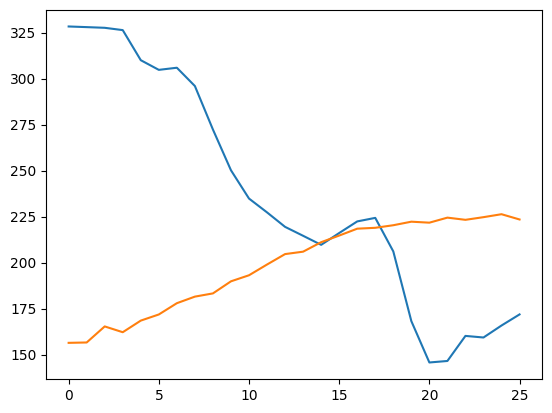

In [ ]:
plt.plot(real)
plt.plot(pred)

## Test (Evaluation)

In [ ]:
oracle_df = oracle_df.rename(columns = {'Date':'date',
                                      'Data':'data'})

oracle_df['date'] = oracle_df['date'].map(lambda x : datetime.combine(x, datetime.min.time()))

oracle_df = oracle_df.set_index('date')

earliest_time = oracle_df.index.min()

oracle_df_list = []

for label in oracle_df:

    if label == "data":

        ts = oracle_df[label]

        start_date = min(ts.fillna(method='ffill').dropna().index)
        end_date = max(ts.fillna(method='bfill').dropna().index)

        active_range = (ts.index >= start_date) & (ts.index <= end_date)
        ts = ts[active_range].fillna(0.)

        tmp = pd.DataFrame({'Y': ts})
        date = tmp.index

        tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
        tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')

        tmp['days_from_start'] = (date - earliest_time).days
        tmp['date'] = date
        tmp['consumer_id'] = label
        tmp['hour'] = date.hour
        tmp['day'] = date.day
        tmp['day_of_week'] = date.dayofweek
        tmp['month'] = date.month
        tmp['year'] = date.year

        #stack all time series vertically
        oracle_df_list.append(tmp)

    else:
        oracle_df_list.append(oracle_df[label])

time_df = pd.concat(oracle_df_list,axis=1).reset_index(drop=True)
time_df['hours_from_start'] = pd.Series(np.array([i for i in range(time_df.shape[0])]))

In [ ]:
time_df.tail(52+12).head(26+12)

,Y,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month,year,d1,d2
92,204.710,92,2800,2017-09-01,data,0,1,4,9,2017,8344.829,104.155
93,181.638,93,2830,2017-10-01,data,0,1,6,10,2017,8735.993,106.068
94,190.327,94,2861,2017-11-01,data,0,1,2,11,2017,8603.444,106.636
95,239.575,95,2891,2017-12-01,data,0,1,4,12,2017,9066.354,106.116
96,239.705,96,2922,2018-01-01,data,0,1,0,1,2018,9354.000,103.191
97,229.395,97,2953,2018-02-01,data,0,1,3,2,2018,8545.000,102.499
98,218.094,98,2981,2018-03-01,data,0,1,3,3,2018,9506.000,103.160
99,188.305,99,3012,2018-04-01,data,0,1,6,4,2018,8821.000,103.237
100,183.814,100,3042,2018-05-01,data,0,1,1,5,2018,9028.000,106.087
101,198.480,101,3073,2018-06-01,data,0,1,4,6,2018,8976.000,107.359


In [ ]:
pred = np.array(tft.predict(time_df.tail(52+12).head(26+12)).cpu())
pred = pred.reshape(-1,1)

real = np.array(time_df.tail(52).head(26)['Y'])
real

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


array([198.176, 218.182, 221.231, 223.322, 198.574, 208.886, 212.255,
       203.975, 207.358, 196.632, 181.964, 155.324, 143.526, 147.962,
       133.639, 135.779, 150.551, 155.174, 158.502, 127.512, 113.766,
       109.832, 110.839, 105.065, 120.338, 122.86 ])

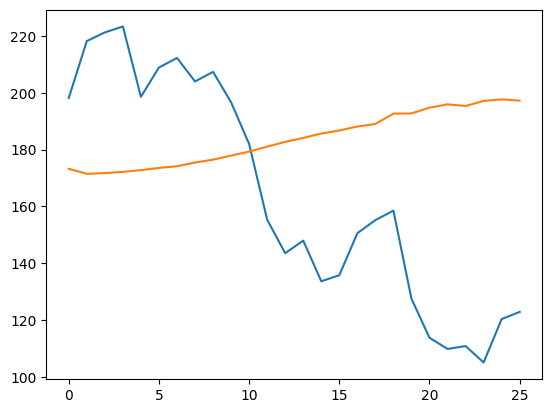

In [ ]:
plt.plot(real)
plt.plot(pred)

In [ ]:
quantile_pred = np.array(tft.predict(time_df.tail(52+12).head(26+12),mode='raw')[0].cpu())

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
quantile_pred = quantile_pred[0]

In [ ]:
quantile_pred

array([[155.02036, 170.22916, 220.13757, 173.22063, 205.23581, 259.34738,
        208.79434],
       [156.26898, 166.1865 , 220.37325, 171.46733, 199.69969, 259.7475 ,
        207.53555],
       [157.13626, 162.66432, 218.98492, 171.71275, 193.97865, 260.02356,
        205.4473 ],
       [157.32242, 160.618  , 218.24571, 172.14476, 191.23773, 260.1063 ,
        204.18091],
       [156.60526, 160.5477 , 220.97984, 172.7573 , 193.59717, 259.37042,
        205.09619],
       [156.53015, 159.12305, 220.97511, 173.55424, 191.90977, 259.27255,
        204.28821],
       [157.47935, 157.81625, 219.48444, 174.12347, 189.45203, 259.35358,
        202.8703 ],
       [156.79703, 156.04253, 220.31375, 175.437  , 187.49048, 259.22397,
        201.8356 ],
       [158.12735, 155.07108, 219.09946, 176.44223, 185.37218, 259.0865 ,
        200.27211],
       [158.06355, 155.00674, 221.73972, 177.89133, 187.00208, 257.8981 ,
        200.76463],
       [159.18846, 154.16278, 221.5383 , 179.28517, 185.3551

In [ ]:
q1 = quantile_pred[:,0]
q2 = quantile_pred[:,1]
q3 = quantile_pred[:,2]
#q4 = quantile_pred[:,3]
#q5 = quantile_pred[:,4]
#q6 = quantile_pred[:,5]
#q7 = quantile_pred[:,6]

In [ ]:
q2

array([170.22916, 166.1865 , 162.66432, 160.618  , 160.5477 , 159.12305,
       157.81625, 156.04253, 155.07108, 155.00674, 154.16278, 152.40967,
       151.32419, 151.1576 , 150.50378, 150.7826 , 150.22346, 149.24261,
       145.93443, 135.9285 , 141.90216, 144.56033, 146.56883, 147.30397,
       146.26836, 146.92024], dtype=float32)

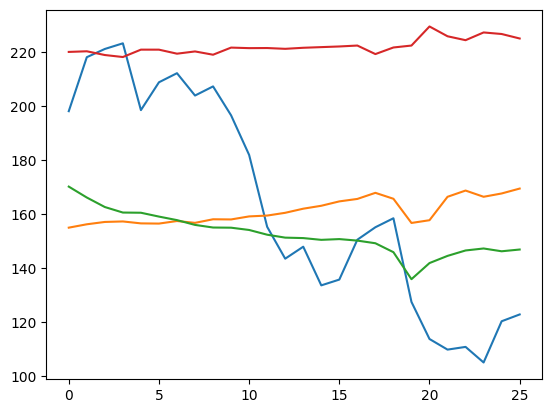

In [ ]:
plt.plot(real)
plt.plot(q1)
plt.plot(q2)
plt.plot(q3)
#plt.plot(q4)
#plt.plot(q5)
#plt.plot(q6)
#plt.plot(q7)